# PaDiM Baseline Training (Clean Domain)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/main/notebooks/05_padim_clean.ipynb)


**Patch Distribution Modeling (PaDiM)** [Defard et al., 2020]

- Extracts multi-scale features from ResNet
- Models normal appearance using Gaussian distributions
- Uses Mahalanobis distance for anomaly scoring
- **No gradient-based training** (statistical approach)

---

## Setup - Mount Drive & Configure Paths

In [1]:
from google.colab import drive
from pathlib import Path
import os
import sys

# Mount Google Drive
drive.mount('/content/drive')

repo_dir = '/content/Detection-of-Anomalies-with-Localization'

# Remove if exists
if os.path.exists(repo_dir):
    print("Removing existing repository...")
    !rm -rf {repo_dir}

# Clone from main branch
!git clone   https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git {repo_dir}


# Set project root
PROJECT_ROOT = Path(repo_dir)
sys.path.insert(0, str(PROJECT_ROOT))

Mounted at /content/drive
Cloning into '/content/Detection-of-Anomalies-with-Localization'...
remote: Enumerating objects: 1237, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 1237 (delta 31), reused 56 (delta 19), pack-reused 1126 (from 3)
Receiving objects: 100% (1237/1237), 419.26 MiB | 27.01 MiB/s, done.
Resolving deltas: 100% (649/649), done.
Filtering content: 100% (30/30), 1.32 GiB | 60.19 MiB/s, done.


For this experiments, we use PaDiM as a baseline method, so we utilized the anomalib implementation of PaDiM.

In [2]:
!pip install anomalib --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 61.0 MB/s eta 0:00:00


## Imports & Configurations

In [3]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import json
import zipfile

# Project imports
from src.models.padim_wrapper import PadimWrapper
from src.data.dataset import MVTecDataset
from src.data.transforms import get_clean_transforms
from src.utils.config import load_config
from src.data.splitter import load_splits
from src.utils.reproducibility import set_seed
from src.utils.paths import ProjectPaths
from src.utils.utils import custom_collate_fn, denormalize_image


In [4]:
# Load configuration
config = load_config(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')
paths = ProjectPaths(PROJECT_ROOT)

# Settings
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
NUM_WORKERS = 2
CLASSES = config.dataset.classes  # ['hazelnut', 'carpet', 'zipper']

# Set seed for reproducibility
set_seed(config.seed)

print(f"\n[INFO] PaDiM Configuration:")
print(f"  Backbone: {config.padim.backbone}")
print(f"  Layers: {config.padim.layers}")
print(f"  Feature dimension: {config.padim.n_features}")
print(f"  Device: {DEVICE}")
print(f"  Classes: {CLASSES}")

Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml

[INFO] PaDiM Configuration:
  Backbone: resnet50
  Layers: ['layer1', 'layer2', 'layer3']
  Feature dimension: 100
  Device: cuda
  Classes: ['hazelnut', 'carpet', 'zipper']


## Load clean splits

Load clean domain splits computed in previous notebook.

In [5]:

splits = load_splits(paths.get_split_path('clean'))

print("Dataset splits loaded:")
print("=" * 70)
for class_name in config.dataset.classes:
    print(f"\n{class_name.upper()}:")
    for split_name in ['train', 'val', 'test']:
        split_data = splits[class_name][split_name]
        n_normal = sum(1 for l in split_data['labels'] if l == 0)
        n_anomalous = sum(1 for l in split_data['labels'] if l == 1)
        print(f"  {split_name:5s}: {len(split_data['labels']):4d} images "
              f"({n_normal:3d} normal, {n_anomalous:3d} anomalous)")

Dataset splits loaded:

HAZELNUT:
  train:  312 images (312 normal,   0 anomalous)
  val  :  100 images ( 79 normal,  21 anomalous)
  test :   89 images ( 40 normal,  49 anomalous)

CARPET:
  train:  224 images (224 normal,   0 anomalous)
  val  :   82 images ( 56 normal,  26 anomalous)
  test :   91 images ( 28 normal,  63 anomalous)

ZIPPER:
  train:  192 images (192 normal,   0 anomalous)
  val  :   83 images ( 48 normal,  35 anomalous)
  test :  116 images ( 32 normal,  84 anomalous)


In [6]:
transform = get_clean_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std
)

# Helper function to create DataLoader
def create_dataloader(split_dict, batch_size=32, shuffle=False):
    """Create DataLoader from split dict (same format as PatchCore)."""
    dataset = MVTecDataset(
        images=split_dict['images'],
        masks=split_dict['masks'],
        labels=split_dict['labels'],
        transform=transform,
        phase='train' if shuffle else 'val'
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True if DEVICE == 'cuda' else False,
        collate_fn=custom_collate_fn  # Use custom collate to handle None masks
    )

    return loader


## Train PaDiM on Clean Domain

Train one PaDiM model per class using the clean splits.

In [7]:
# Initialize results tracking
MODEL_DIR = PROJECT_ROOT / 'outputs' / 'models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

training_results = {
    'classes': [],
    'num_train_samples': [],
    'training_time_seconds': [],
    'memory_bank_size_mb': [],
    'model_path': []
}

trained_models = {}

In [8]:
print("\n" + "="*80)
print("[START] TRAINING PaDiM MODELS")
print("="*80 + "\n")

for class_name in CLASSES:
    print(f"\n{'='*80}")
    print(f"[TRAIN] PaDiM: {class_name.upper()}")
    print(f"{'='*80}\n")

    # 1. Load data
    split_data = splits[class_name]
    train_loader = create_dataloader(
        split_dict=split_data['train'],
        batch_size=BATCH_SIZE,
        shuffle=False  # No shuffle for deterministic training
    )

    print(f"[OK] Loaded {len(train_loader.dataset)} training samples\n")

    # 2. Initialize model
    model = PadimWrapper(
        backbone=config.padim.backbone,
        layers=config.padim.layers,
        n_features=config.padim.n_features,
        image_size=config.dataset.image_size,
        device=DEVICE
    )

    # 3. Train (fit on normal samples)
    model.fit(train_loader, verbose=True)

    # 4. Save
    model_path = MODEL_DIR / f"padim_{class_name}_clean.pt"
    model.save(model_path, include_stats=True)

    # 5. Store results
    training_results['classes'].append(class_name)
    training_results['num_train_samples'].append(model.training_stats['num_samples'])
    training_results['training_time_seconds'].append(model.training_stats['training_time_seconds'])
    training_results['memory_bank_size_mb'].append(model.training_stats['memory_bank_size_mb'])
    training_results['model_path'].append(str(model_path))

    trained_models[class_name] = model

    print(f"\n[COMPLETE] {class_name}")
    print(f"   Model: {model_path.name}")
    print(f"   Time: {model.training_stats['training_time_seconds']:.2f}s")

print(f"\n{'='*80}")
print("[SUCCESS] ALL CLASSES TRAINED SUCCESSFULLY!")
print(f"{'='*80}\n")


[START] TRAINING PaDiM MODELS


[TRAIN] PaDiM: HAZELNUT

[OK] Loaded 312 training samples



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]


Training PaDiM on 312 normal samples
Backbone: resnet50 | Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Device: cuda



Extracting features: 100%|██████████| 10/10 [01:22<00:00,  8.28s/it]



Fitting Gaussian distributions...
  Total samples: 312
  Memory bank size: 10 batches

[OK] Training completed in 83.92s
  Gaussian mean shape: torch.Size([100, 3136])
  Inv covariance shape: torch.Size([3136, 100, 100])
  Memory usage: 120.83 MB

[OK] Model saved: padim_hazelnut_clean.pt
  Stats saved: padim_hazelnut_clean.json

[COMPLETE] hazelnut
   Model: padim_hazelnut_clean.pt
   Time: 83.92s

[TRAIN] PaDiM: CARPET

[OK] Loaded 224 training samples


Training PaDiM on 224 normal samples
Backbone: resnet50 | Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Device: cuda



Extracting features: 100%|██████████| 7/7 [01:01<00:00,  8.82s/it]



Fitting Gaussian distributions...
  Total samples: 224
  Memory bank size: 7 batches

[OK] Training completed in 62.26s
  Gaussian mean shape: torch.Size([100, 3136])
  Inv covariance shape: torch.Size([3136, 100, 100])
  Memory usage: 120.83 MB

[OK] Model saved: padim_carpet_clean.pt
  Stats saved: padim_carpet_clean.json

[COMPLETE] carpet
   Model: padim_carpet_clean.pt
   Time: 62.26s

[TRAIN] PaDiM: ZIPPER

[OK] Loaded 192 training samples


Training PaDiM on 192 normal samples
Backbone: resnet50 | Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Device: cuda



Extracting features: 100%|██████████| 6/6 [00:41<00:00,  6.99s/it]



Fitting Gaussian distributions...
  Total samples: 192
  Memory bank size: 6 batches

[OK] Training completed in 42.45s
  Gaussian mean shape: torch.Size([100, 3136])
  Inv covariance shape: torch.Size([3136, 100, 100])
  Memory usage: 120.83 MB

[OK] Model saved: padim_zipper_clean.pt
  Stats saved: padim_zipper_clean.json

[COMPLETE] zipper
   Model: padim_zipper_clean.pt
   Time: 42.45s

[SUCCESS] ALL CLASSES TRAINED SUCCESSFULLY!



## Training Results

In [9]:
# Save training results to JSON
results_path = PROJECT_ROOT / 'outputs' / 'results' / 'padim_training_results_clean.json'
results_path.parent.mkdir(parents=True, exist_ok=True)

with open(results_path, 'w') as f:
    json.dump(training_results, f, indent=2)

# Save as CSV for easy viewing
import pandas as pd
results_df = pd.DataFrame(training_results)
csv_path = PROJECT_ROOT / 'outputs' / 'results' / 'padim_training_stats_clean.csv'
results_df.to_csv(csv_path, index=False)

In [10]:
# Save training statistics as CSV
import pandas as pd

stats_data = []
for class_name in CLASSES:
    model = trained_models[class_name]
    stats = model.training_stats
    stats_data.append({
        'class': class_name,
        'n_train_images': stats['num_samples'],
        'n_features': stats.get('n_features', 100),
        'spatial_resolution': f"{stats.get('spatial_h', 56)}x{stats.get('spatial_w', 56)}",
        'training_time': f"{stats['training_time_seconds']:.2f}s",
        'model_size_mb': stats['memory_bank_size_mb']
    })

stats_df = pd.DataFrame(stats_data)

print("\nTraining Statistics Summary:")
print("="*70)
print(stats_df.to_string(index=False))
print("="*70)

# Save CSV
stats_csv_path = PROJECT_ROOT / 'outputs' / 'results' / 'padim_clean_training_stats.csv'
stats_csv_path.parent.mkdir(parents=True, exist_ok=True)
stats_df.to_csv(stats_csv_path, index=False)
print(f"\nStatistics saved to: {stats_csv_path}")


Training Statistics Summary:
   class  n_train_images  n_features spatial_resolution training_time  model_size_mb
hazelnut             312         100              56x56        83.92s     120.825195
  carpet             224         100              56x56        62.26s     120.825195
  zipper             192         100              56x56        42.45s     120.825195

Statistics saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/padim_clean_training_stats.csv


## Save Complete Metadata with Validation Scores

Generate comprehensive metadata for fair comparison with PatchCore.

In [11]:
import json
from datetime import datetime

print(f"\n{'='*80}")
print("[METADATA] Collecting validation predictions for all classes")
print("="*80 + "\n")

# Collect validation scores for threshold calibration
validation_predictions = {}

for class_name in CLASSES:
    model = trained_models[class_name]
    split_data = splits[class_name]

    # Create val loader
    val_loader = create_dataloader(
        split_dict=split_data['val'],
        batch_size=8,
        shuffle=False
    )

    # Get predictions for all validation images
    all_scores = []
    all_labels = []
    all_paths = []

    for images, masks, labels, paths in val_loader:
        scores, _ = model.predict(images, return_heatmaps=False)

        # Handle scalar vs array
        if isinstance(scores, np.ndarray):
            all_scores.extend(scores.tolist())
        else:
            all_scores.append(scores)

        all_labels.extend(labels.tolist())
        all_paths.extend(paths)

    # Calculate statistics
    normal_scores = [s for s, l in zip(all_scores, all_labels) if l == 0]
    anomalous_scores = [s for s, l in zip(all_scores, all_labels) if l == 1]

    validation_predictions[class_name] = {
        'scores': all_scores,
        'labels': all_labels,
        'image_paths': all_paths,
        'n_normal': len(normal_scores),
        'n_anomalous': len(anomalous_scores),
        'score_stats': {
            'normal_mean': float(np.mean(normal_scores)),
            'normal_std': float(np.std(normal_scores)),
            'anomalous_mean': float(np.mean(anomalous_scores)),
            'anomalous_std': float(np.std(anomalous_scores))
        }
    }

    print(f"[OK] {class_name.upper()}: "
          f"Normal={validation_predictions[class_name]['score_stats']['normal_mean']:.1f}±"
          f"{validation_predictions[class_name]['score_stats']['normal_std']:.1f}, "
          f"Anomalous={validation_predictions[class_name]['score_stats']['anomalous_mean']:.1f}±"
          f"{validation_predictions[class_name]['score_stats']['anomalous_std']:.1f}")

# Create comprehensive metadata
metadata = {
    'notebook': '05_padim_clean.ipynb',
    'timestamp': datetime.now().isoformat(),
    'seed': 42,
    'device': DEVICE,

    'configuration': {
        'backbone': 'resnet50',
        'layers': ['layer1', 'layer2', 'layer3'],
        'n_features': 100,
        'batch_size': 8,
        'image_size': 224,
        'normalize_mean': [0.485, 0.456, 0.406],
        'normalize_std': [0.229, 0.224, 0.225]
    },

    'training_statistics': {},
    'validation_predictions': validation_predictions,

    'models_saved': {},
    'splits_used': 'clean_splits.json'
}

# Add training statistics per class
for class_name in CLASSES:
    model = trained_models[class_name]
    stats = model.training_stats
    metadata['training_statistics'][class_name] = {
        'n_train_images': stats['num_samples'],
        'n_features': stats.get('n_features', 100),
        'spatial_dims': [stats.get('spatial_h', 56), stats.get('spatial_w', 56)],
        'training_time_seconds': stats['training_time_seconds'],
        'model_size_mb': stats['memory_bank_size_mb']
    }

    metadata['models_saved'][class_name] = {
        'model': f"padim_{class_name}_clean.pt",
        'config': f"padim_{class_name}_clean.json",
        'location': str(MODEL_DIR)
    }

# Save metadata
metadata_path = PROJECT_ROOT / 'outputs' / 'results' / 'padim_clean_metadata.json'
metadata_path.parent.mkdir(parents=True, exist_ok=True)

with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n{'='*80}")
print(f"[OK] Metadata saved to: {metadata_path}")
print(f"\nSummary:")
print(f"  Classes trained: {len(CLASSES)}")
print(f"  Total train images: {sum(trained_models[c].training_stats['num_samples'] for c in CLASSES)}")
print(f"  Average training time: {np.mean([trained_models[c].training_stats['training_time_seconds'] for c in CLASSES]):.2f}s")
print(f"  Models saved in: {MODEL_DIR}")
print("="*80)


[METADATA] Collecting validation predictions for all classes

[OK] HAZELNUT: Normal=28.9±9.1, Anomalous=71.2±23.3
[OK] CARPET: Normal=19.2±5.7, Anomalous=91.7±61.5
[OK] ZIPPER: Normal=19.0±8.7, Anomalous=57.8±35.7

[OK] Metadata saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/padim_clean_metadata.json

Summary:
  Classes trained: 3
  Total train images: 728
  Average training time: 62.88s
  Models saved in: /content/Detection-of-Anomalies-with-Localization/outputs/models




Visual Validation

[OK] Predictions generated:
  Normal score: 19.7701
  Anomalous score: 62.0365
  Global heatmap vmax: 62.036



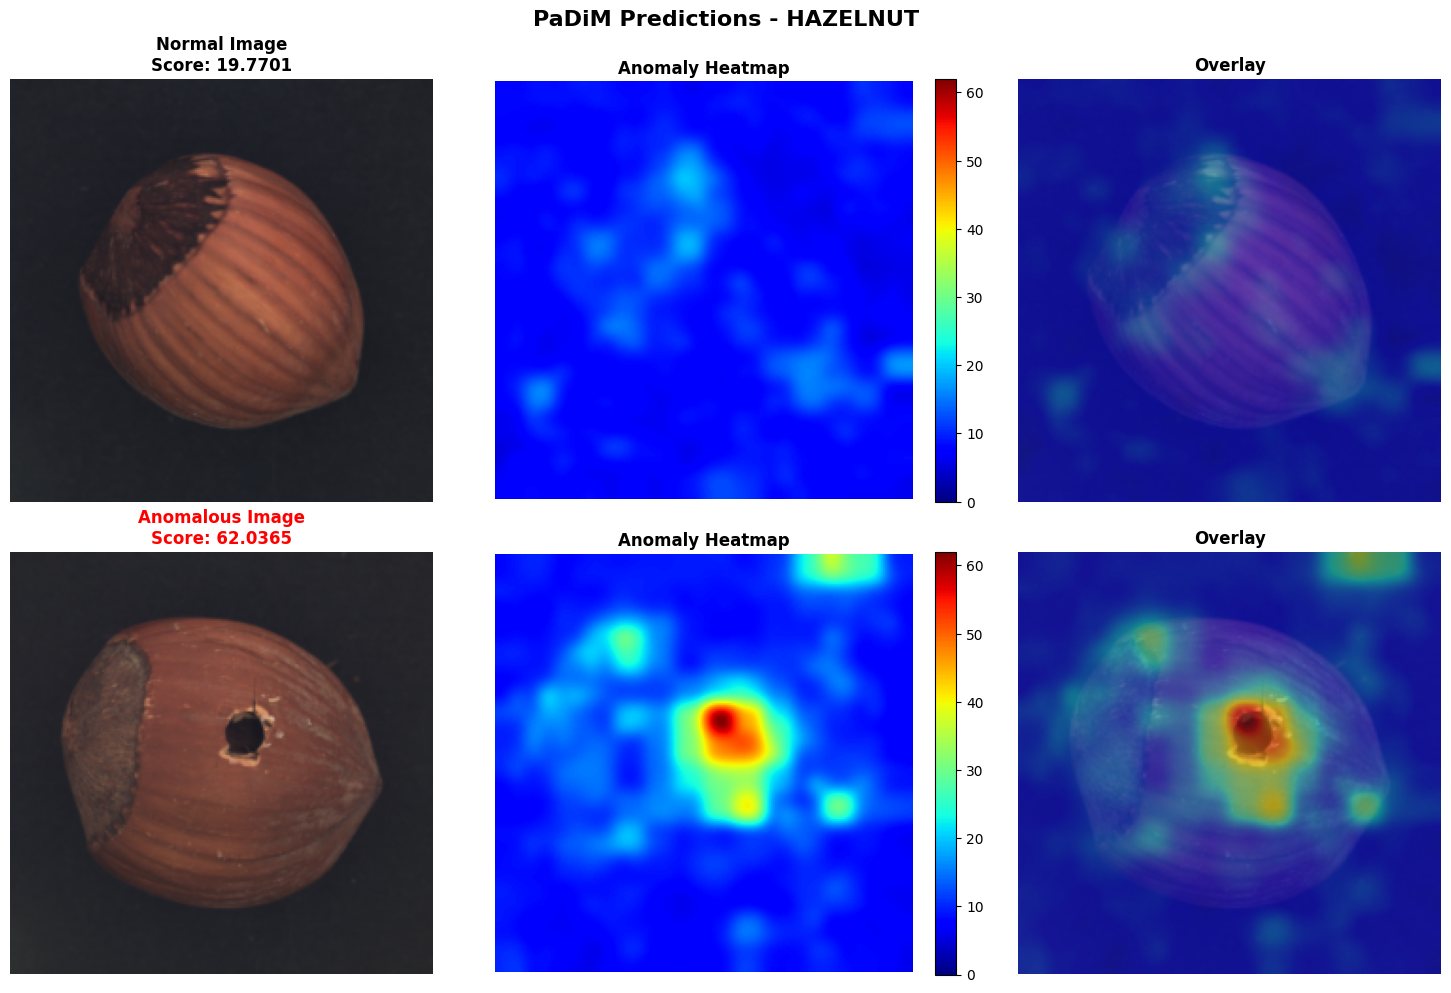

In [15]:
# TEST: Visual validation
print(f"\n\n{'='*80}")
print("Visual Validation")
print("="*80 + "\n")

# Select one class for visualization
TEST_CLASS = CLASSES[0]
model = trained_models[TEST_CLASS]
split_data = splits[TEST_CLASS]

# Create val loader
val_loader = create_dataloader(
    split_dict=split_data['val'],
    batch_size=1,
    shuffle=False
)

# Get one normal and one anomalous sample
normal_images = None
anomalous_images = None

for images, masks, labels, paths in val_loader:
    if labels.item() == 0 and normal_images is None:
        normal_images = images
    elif labels.item() == 1 and anomalous_images is None:
        anomalous_images = images

    if normal_images is not None and anomalous_images is not None:
        break

# Predict
normal_score, normal_heatmap = model.predict(normal_images, return_heatmaps=True)
anomalous_score, anomalous_heatmap = model.predict(anomalous_images, return_heatmaps=True)

# Handle scalar vs array
if isinstance(normal_score, np.ndarray):
    normal_score = normal_score.item()
if isinstance(anomalous_score, np.ndarray):
    anomalous_score = anomalous_score.item()

# Squeeze heatmaps to remove batch dimension (1, H, W) -> (H, W)
if normal_heatmap is not None and normal_heatmap.ndim == 3:
    normal_heatmap = normal_heatmap.squeeze(0)
if anomalous_heatmap is not None and anomalous_heatmap.ndim == 3:
    anomalous_heatmap = anomalous_heatmap.squeeze(0)

# Calculate global vmax for consistent heatmap scaling
vmax_global = np.max([normal_heatmap.max(), anomalous_heatmap.max()])

print(f"[OK] Predictions generated:")
print(f"  Normal score: {normal_score:.4f}")
print(f"  Anomalous score: {anomalous_score:.4f}")
print(f"  Global heatmap vmax: {vmax_global:.3f}\n")

mean = config.dataset.normalize.mean
std = config.dataset.normalize.std

normal_img = denormalize_image(normal_images[0].cpu(), mean, std)

anomalous_img = denormalize_image(anomalous_images[0].cpu(), mean, std)

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Normal sample
axes[0, 0].imshow(normal_img)
axes[0, 0].set_title(f'Normal Image\nScore: {normal_score:.4f}', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

im1 = axes[0, 1].imshow(normal_heatmap, cmap='jet', vmin=0, vmax=vmax_global)
axes[0, 1].set_title('Anomaly Heatmap', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

axes[0, 2].imshow(normal_img)
axes[0, 2].imshow(normal_heatmap, cmap='jet', alpha=0.5, vmin=0, vmax=vmax_global)
axes[0, 2].set_title('Overlay', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# Anomalous sample
axes[1, 0].imshow(anomalous_img)
axes[1, 0].set_title(f'Anomalous Image\nScore: {anomalous_score:.4f}', fontsize=12, fontweight='bold', color='red')
axes[1, 0].axis('off')

im2 = axes[1, 1].imshow(anomalous_heatmap, cmap='jet', vmin=0, vmax=vmax_global)
axes[1, 1].set_title('Anomaly Heatmap', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1], fraction=0.046)

axes[1, 2].imshow(anomalous_img)
axes[1, 2].imshow(anomalous_heatmap, cmap='jet', alpha=0.5, vmin=0, vmax=vmax_global)
axes[1, 2].set_title('Overlay', fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

plt.suptitle(f'PaDiM Predictions - {TEST_CLASS.upper()}', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## Save Visualizations as PNG Files

In [17]:

VIZ_DIR = PROJECT_ROOT / 'outputs' / 'visualizations'
VIZ_DIR.mkdir(parents=True, exist_ok=True)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

print(f"\n{'='*80}")
print("[VISUALIZATIONS] Generating and saving PNG files for all classes")
print("="*80 + "\n")

for class_name in CLASSES:
    model = trained_models[class_name]
    split_data = splits[class_name]

    # Create val loader
    val_loader = create_dataloader(
        split_dict=split_data['val'],
        batch_size=1,
        shuffle=False
    )

    # Select images: 4 normal + 4 anomalous
    normal_images = []
    normal_labels = []
    anomalous_images = []
    anomalous_labels = []

    for images, masks, labels, paths in val_loader:
        if labels.item() == 0 and len(normal_images) < 4:
            normal_images.append(images[0])
            normal_labels.append(labels.item())
        elif labels.item() == 1 and len(anomalous_images) < 4:
            anomalous_images.append(images[0])
            anomalous_labels.append(labels.item())

        if len(normal_images) == 4 and len(anomalous_images) == 4:
            break

    # Combine
    test_images = normal_images + anomalous_images
    test_labels = normal_labels + anomalous_labels

    # Get predictions
    test_batch = torch.stack(test_images)
    scores, heatmaps = model.predict(test_batch, return_heatmaps=True)

    # Handle scalar vs array
    if isinstance(scores, np.ndarray) and scores.ndim == 0:
        scores = np.array([scores.item()])
    elif not isinstance(scores, np.ndarray):
        scores = np.array([scores])

    # Ensure scores are always a 1D array of floats for consistent indexing and item() usage
    scores = scores.flatten().astype(float)

    # Squeeze heatmaps if needed (B, H, W) or (H, W)
    heatmaps_list = []
    for h in heatmaps:
        if isinstance(h, np.ndarray) and h.ndim == 3:
            heatmaps_list.append(h.squeeze(0))
        else:
            heatmaps_list.append(h)
    heatmaps = heatmaps_list

    # Calculate global vmax for consistent heatmap scaling
    vmax_global = np.max([h.max() for h in heatmaps])

    # Create figure
    fig, axes = plt.subplots(2, 8, figsize=(20, 5))

    for i, (img, score, heatmap, label) in enumerate(
        zip(test_images, scores, heatmaps, test_labels)
    ):
        # Denormalize image using utility function
        img_np = denormalize_image(img.cpu(), mean, std)

        # Original image
        axes[0, i].imshow(img_np)
        axes[0, i].set_title(
            f"{'Normal' if label == 0 else 'Anomalous'}\nScore: {score:.1f}",
            fontsize=10
        )
        axes[0, i].axis('off')

        # Heatmap overlay with global normalization
        axes[1, i].imshow(img_np)
        axes[1, i].imshow(heatmap, alpha=0.5, cmap='jet', vmin=0, vmax=vmax_global)
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('Original', fontsize=12)
    axes[1, 0].set_ylabel('Heatmap', fontsize=12)

    plt.suptitle(f'PaDiM Predictions - {class_name.upper()}', fontsize=16, y=1.02)
    plt.tight_layout()

    # Save
    save_path = VIZ_DIR / f'padim_clean_{class_name}_validation.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"[OK] Saved: {save_path.name}")



[VISUALIZATIONS] Generating and saving PNG files for all classes

[OK] Saved: padim_clean_hazelnut_validation.png
[OK] Saved: padim_clean_carpet_validation.png
[OK] Saved: padim_clean_zipper_validation.png


## Save to Google Drive

Copy all outputs to Google Drive

In [18]:
import shutil

# Create output directory in Google Drive
DRIVE_OUTPUT = Path('/content/drive/MyDrive/anomaly_detection_project/05_padim_clean_outputs')
DRIVE_OUTPUT.mkdir(parents=True, exist_ok=True)

print("="*70)
print("[SAVE] Copying outputs to Google Drive...")
print("="*70 + "\n")

# 1. Copy model files
models_saved = []
for class_name in CLASSES:
    model_file = MODEL_DIR / f"padim_{class_name}_clean.pt"
    stats_file = MODEL_DIR / f"padim_{class_name}_clean.json"

    if model_file.exists():
        shutil.copy2(model_file, DRIVE_OUTPUT / model_file.name)
        models_saved.append(model_file.name)
        print(f"[OK] Saved: {model_file.name}")

    if stats_file.exists():
        shutil.copy2(stats_file, DRIVE_OUTPUT / stats_file.name)
        print(f"[OK] Saved: {stats_file.name}")

# 2. Copy results files
results_files = [
    (PROJECT_ROOT / 'outputs' / 'results' / 'padim_clean_training_stats.csv', 'padim_clean_training_stats.csv'),
    (PROJECT_ROOT / 'outputs' / 'results' / 'padim_clean_metadata.json', 'padim_clean_metadata.json'),
    (PROJECT_ROOT / 'outputs' / 'results' / 'padim_training_results_clean.json', 'padim_training_results_clean.json')
]

for src, dst_name in results_files:
    if src.exists():
        shutil.copy2(src, DRIVE_OUTPUT / dst_name)
        print(f"[OK] Saved: {dst_name}")

# 3. Copy visualization files
viz_files = []
for class_name in CLASSES:
    viz_file = PROJECT_ROOT / 'outputs' / 'visualizations' / f"padim_clean_{class_name}_validation.png"
    if viz_file.exists():
        shutil.copy2(viz_file, DRIVE_OUTPUT / viz_file.name)
        viz_files.append(viz_file.name)
        print(f"[OK] Saved: {viz_file.name}")

print("\n" + "="*70)
print("[SUCCESS] OUTPUTS SAVED TO GOOGLE DRIVE!")
print("="*70)
print(f"Location: {DRIVE_OUTPUT}")
print(f"Total files: {len(list(DRIVE_OUTPUT.iterdir()))}")
print(f"Total size: {sum(f.stat().st_size for f in DRIVE_OUTPUT.iterdir() if f.is_file()) / (1024*1024):.2f} MB")
print("\nFiles saved:")
print(f"  - {len(models_saved)} model files (.pt + .json)")
print(f"  - {len(results_files)} result files (.csv + .json)")
print(f"  - {len(viz_files)} visualization files (.png)")
print("="*70)

[SAVE] Copying outputs to Google Drive...

[OK] Saved: padim_hazelnut_clean.pt
[OK] Saved: padim_hazelnut_clean.json
[OK] Saved: padim_carpet_clean.pt
[OK] Saved: padim_carpet_clean.json
[OK] Saved: padim_zipper_clean.pt
[OK] Saved: padim_zipper_clean.json
[OK] Saved: padim_clean_training_stats.csv
[OK] Saved: padim_clean_metadata.json
[OK] Saved: padim_training_results_clean.json
[OK] Saved: padim_clean_hazelnut_validation.png
[OK] Saved: padim_clean_carpet_validation.png
[OK] Saved: padim_clean_zipper_validation.png

[SUCCESS] OUTPUTS SAVED TO GOOGLE DRIVE!
Location: /content/drive/MyDrive/anomaly_detection_project/05_padim_clean_outputs
Total files: 12
Total size: 367.56 MB

Files saved:
  - 3 model files (.pt + .json)
  - 3 result files (.csv + .json)
  - 3 visualization files (.png)


---
## Files Generated

This notebook generates the following files:

**Models** (`outputs/models/`):
- `padim_hazelnut_clean.pt` - Gaussian parameters
- `padim_hazelnut_clean.json` - Model config
- `padim_carpet_clean.pt` - Gaussian parameters
- `padim_carpet_clean.json` - Model config
- `padim_zipper_clean.pt` - Gaussian parameters
- `padim_zipper_clean.json` - Model config

**Results** (`outputs/results/`):
- `padim_clean_training_stats.csv` - Training statistics (comparable with PatchCore)
- `padim_clean_metadata.json` - Complete metadata with validation scores
- `padim_training_results_clean.json` - Basic training results

**Visualizations** (`outputs/visualizations/`):
- `padim_clean_hazelnut_validation.png` - Validation predictions
- `padim_clean_carpet_validation.png` - Validation predictions
- `padim_clean_zipper_validation.png` - Validation predictions

